# <center> Decision Tree Model

## Load Pacakage.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree
import os
import plotly.express as px
from sklearn.model_selection import cross_val_score, cross_validate

## Load data

In [2]:
Clean_DF = pd.read_csv('../data/Steam_Clean_Data.csv')
Train_reco = pd.read_csv('../data/Train_reco.csv')
Test_reco = pd.read_csv('../data/Test_reco.csv')

## Transform Recomendation Data.

Use tfidvectorizer to transform text data

In [3]:
## Instantiate the TfidfVectorizer
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
DTM_reco=Tfidf_reco.fit_transform(Clean_DF['review'])

Convert tfidvectorizer result to pandas data frame.

In [4]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DTM_DF_reco=pd.DataFrame(DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())


C:\Users\25465\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Recommendation Model

### Base Model

Set an instantiate logistic model

In [7]:
## Instantiate the Decision Tree Model and Fit the Data
MyDT_reco=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            #min_impurity_split=None, 
                            class_weight=None)

Use trian data to fit the model.

In [8]:
MyDT_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

feature_names = Train_DTM_DF_reco.columns
class_names = Train_reco['recommendation'].unique()

Predict the test data

In [9]:
DT_pred_reco=MyDT_reco.predict(Test_DTM_DF_reco)

Create a confusion matrix


The confusion matrix is:
[[11760 15861]
 [ 3932 52263]]


C:\Users\25465\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


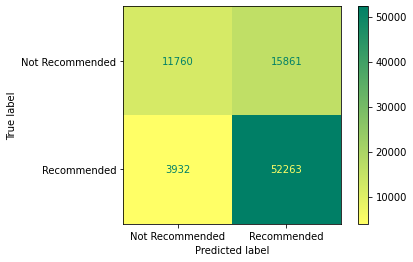


The accuracy of Decision Tree model is: 0.7638517705450033


<Figure size 432x288 with 0 Axes>

In [10]:
## Evaluate the Models with Confusion Matrix and Accuracy
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(MyDT_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
plt.show()
plt.savefig('../Visualizations/MyTree1_cm.png')
print("\nThe accuracy of Decision Tree model is:",accuracy_score(Test_reco['recommendation'], DT_pred_reco))

### Cross Validation

Convert model to integer. 

In [11]:
Label = [1 if Clean_DF.iloc[i,1]=="Recommended" else 0 for i in range(len(Clean_DF))]

Use cross valiadation to generate logistic model.

In [12]:
## Cross Validete Function
output = cross_validate(estimator=MyDT_reco, X=DTM_reco, y=Label, 
                            cv=6, scoring=['accuracy','precision','f1'], return_estimator =True)

Print accuracy score

In [13]:
print("The averege accuracy of cross validation is %.2f\n" % output['test_accuracy'].mean())
print("The averege precision of cross validation is %.2f\n" % output['test_precision'].mean())
print("The averege f1 of cross validation is %.2f\n" % output['test_f1'].mean())

The averege accuracy of cross validation is 0.75

The averege precision of cross validation is 0.76

The averege f1 of cross validation is 0.83



## Feature Importance

Create the feature importance for each cross validation.

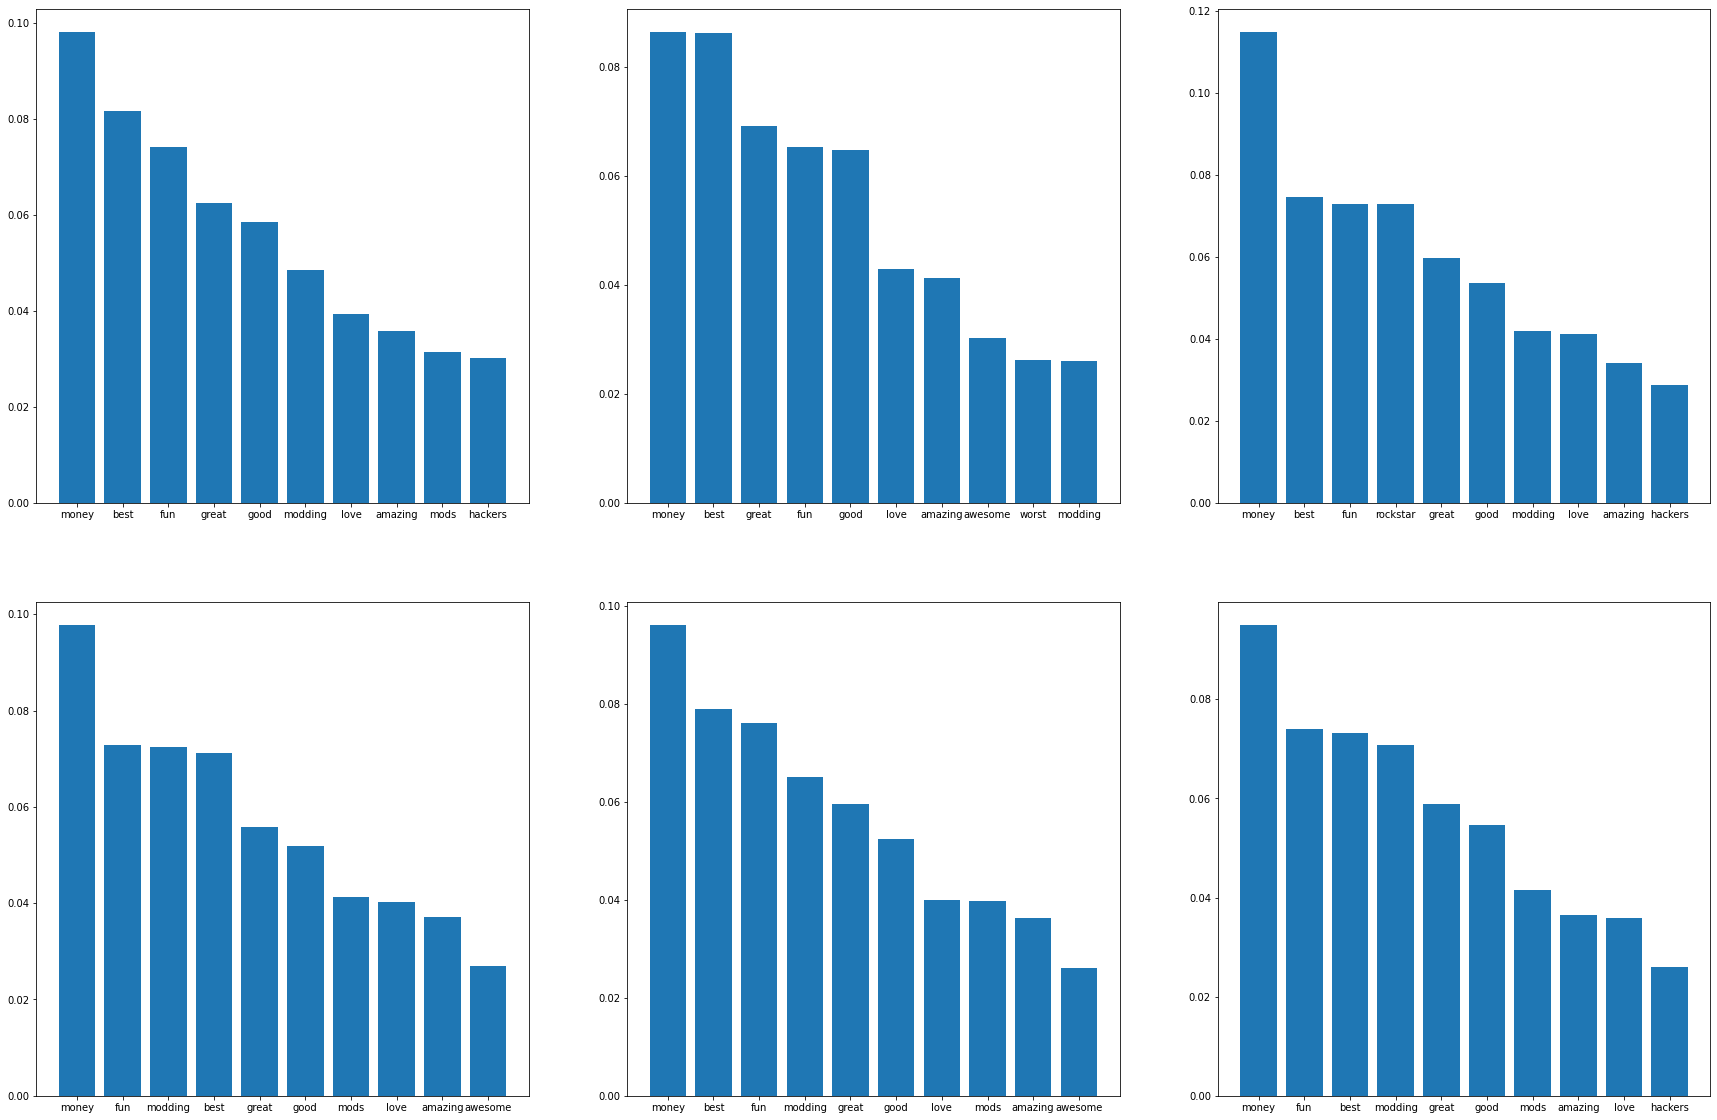

In [14]:
## Visualize the results
fig=plt.figure(figsize=(30,20))

for idx,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = DTM_DF_reco.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    #print(feature_importances[:10:])
    plt.subplot(231+idx)
    plt.bar(x = feature_importances.index[:10:], height=feature_importances["importance"][:10:])
    plt.savefig("../Visualizations/DT_Imp.png")